# Clustering and Viz Experimentation

In [3]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
import os
import sys

module_path = os.path.abspath(os.path.join('rcnn/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels

In [48]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

### importing datasets

In [167]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

class_dict = util.indexed_dictionary

tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
#tiles['028012'] = ['20110831']
#tiles['029011'] = ['20110831']
#tiles['028011'] = ['20110831']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets
    
tile_size = 5
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
epochs = 200
batch_size = 25
clean_pixels_count = 500000
max_count_per_class = 200

In [168]:
image_buckets = rnn_pixels.balanced_pix_data(landsat_datasets, lc_labels, canopy_labels, tile_size, tile_list, 
                           clean_pixels_count, class_count, max_count_per_class, class_dict, buffer_pix=1)

Beginning balanced data creation.
Clean pix generated, starting generator.
Iterating through data and clipping for balance.
Processing Complete.


In [169]:
class_dict

{0: 'Water',
 1: 'Developed',
 2: 'Forest',
 3: 'Cultivated',
 4: 'Barren',
 5: 'Wetland'}

#### Convert the data into the scikit learn format.

Should probably have the function return this format.

In [170]:
sk_labels = []
for class_index, class_bucket in enumerate(image_buckets):
    print(class_bucket.shape)
    sk_labels = sk_labels + [class_index] * class_bucket.shape[0]
sk_labels = np.array(sk_labels)
sk_labels.shape

(200, 1, 4, 7)
(200, 1, 4, 7)
(200, 1, 4, 7)
(200, 1, 4, 7)
(200, 1, 4, 7)
(200, 1, 4, 7)


(1200,)

Continue converting data to scikit-learn format

In [171]:
vstacked_image_buckets = np.vstack(image_buckets)
sk_data = vstacked_image_buckets.reshape(vstacked_image_buckets.shape[0], 
                vstacked_image_buckets.shape[1]*vstacked_image_buckets.shape[2]*vstacked_image_buckets.shape[3])
sk_data.shape

(1200, 28)

## Spectral Signatures

Landsat 5 specs from USGS https://www.usgs.gov/land-resources/nli/landsat/landsat-5

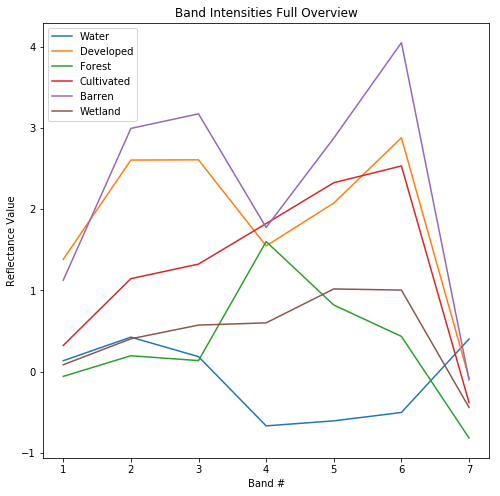

In [172]:
fig, ax = plt.subplots(1,1, figsize=[8,8])

# numbers 1-8
band_count = np.arange(1,8)

for class_index, class_bucket in enumerate(image_buckets):
    band_intensity = np.mean(class_bucket, axis=(0,1,2))
    ax.plot(band_count, band_intensity, label=class_dict[class_index])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')


### Dendrogram

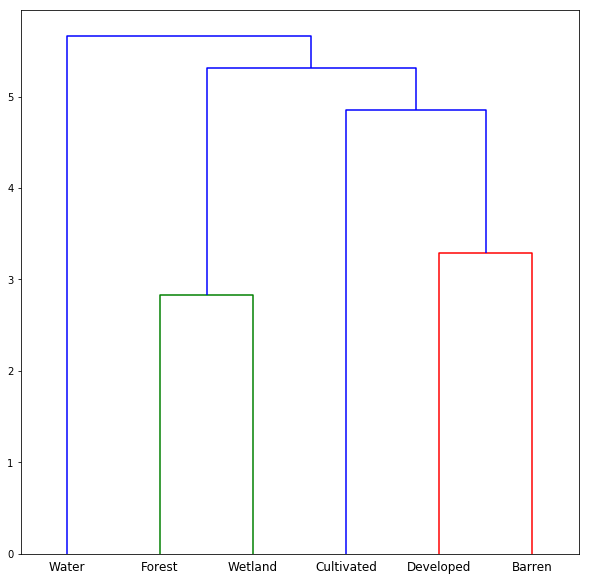

In [173]:
from scipy.cluster import hierarchy

image_avgs = []
for class_bucket in image_buckets:
    image_avgs.append(np.mean(class_bucket, axis=(0,1)).reshape(28))

ytdist = np.array(image_avgs)

Z = hierarchy.linkage(ytdist, 'single')
plt.figure(figsize=(10,10))
dn = hierarchy.dendrogram(Z, labels=list(class_dict.values()))

### PCA and Clustering

In [174]:
import numpy as np
from sklearn.decomposition import IncrementalPCA
X = sk_data
ipca = IncrementalPCA(n_components=2, batch_size=3)
ipca.fit(X)
ipca.transform(X).shape

(1200, 2)

In [175]:
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca_result = pca.fit_transform(sk_data)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

df = pd.DataFrame({'pca-one':pca_result[:,0],'pca-two':pca_result[:,1],'pca-three':pca_result[:,2], 'y' : sk_labels})

Explained variation per principal component: [0.69261836 0.13457466 0.06166585]


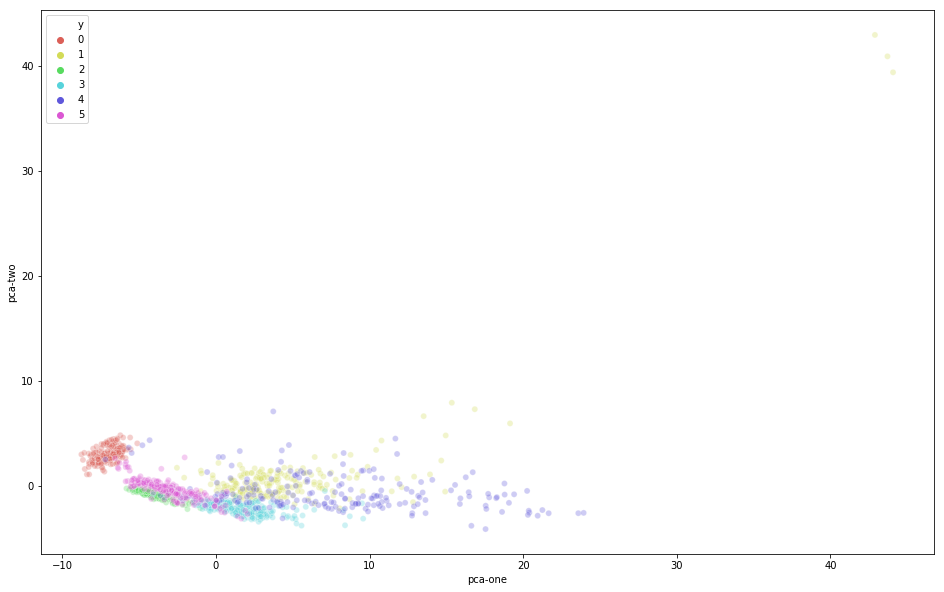

In [176]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(sk_labels))),
    data=df,
    legend="full",
    alpha=0.3
)

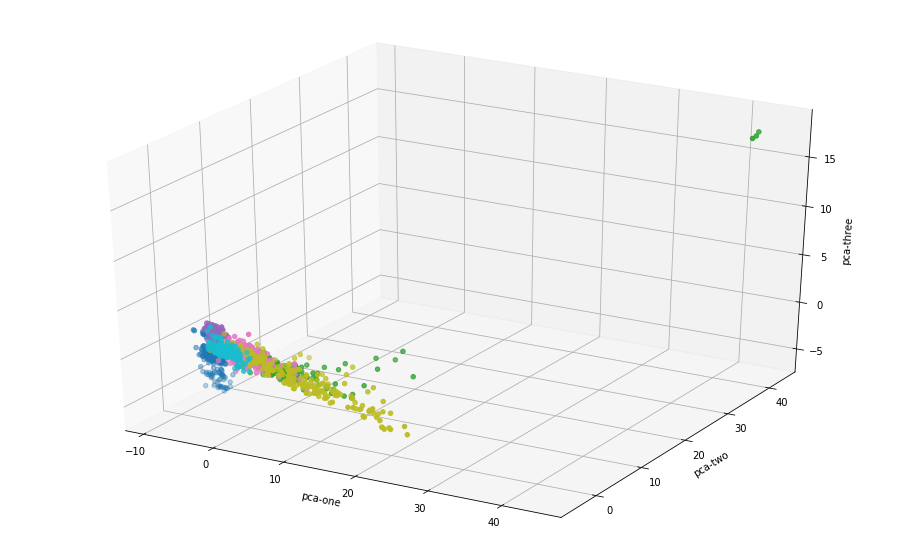

In [177]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=df["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [178]:
from time import time
from sklearn.manifold import TSNE

N = 10000
data_subset = sk_data[:N, :]

time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.001s...
[t-SNE] Computed neighbors for 1200 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 1.040581
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.316284
[t-SNE] KL divergence after 1000 iterations: 0.505554
t-SNE done! Time elapsed: 7.496562242507935 seconds


In [179]:
df_subset = df.loc[:N-1,:].copy()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

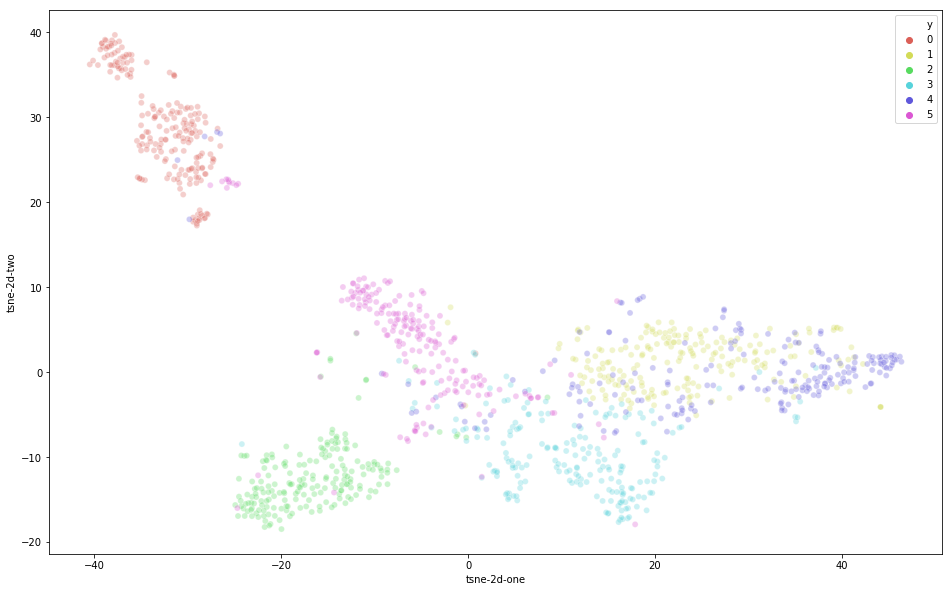

In [180]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", len(np.unique(sk_labels))),
    data=df_subset,
    legend="full",
    alpha=0.3
)